In [1]:
import sys
sys.path.insert(0,'/home/ghcp/Documentos/CINVESTAV/SEMESTRE_1/scripts')
sys.path.insert(0,'/home/ghcp/Documentos/CINVESTAV/ANALISYS_B0tomumuKstar/NOTEBOOKS')
from plot_tools import create_axes_for_pulls, plot_model 
import zfit
import plot_tools 
import numpy as np
import customPDFs
import mass_models
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import seaborn as sns
import mplhep as hep
from zfit import z
import xgboost as xgb
import pandas as pd
import os
pd.set_option('display.max_columns', None)
import uproot3 as uproot
import os, sys
import common_tools
from scipy.stats import gaussian_kde

from zfit import z
from zfit import pdf
import common_tools
from zfit.pdf import Chebyshev  # Correct import path
from scipy.stats import gaussian_kde

/home/ghcp/miniconda3/envs/haza_wokr_env/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/home/ghcp/miniconda3/envs/haza_wokr_env/lib/python3.8/site-packages/zfit/core/basemodel.py:199: UserWarning: For the future, also decorate _pdf with @supports and specify what you support (such as 'norm=True' to keep the same behavior as before)
  warnings.warn(


In [2]:

# Abrimos el archivo
file_Data = uproot.open("/home/ghcp/Documentos/CINVESTAV/ANALISYS_B0tomumuKstar/angular/codes/AntiRadVeto_Data_2022_Era1_v1_XGBoost_fom_cut.root") 
tree_Data = file_Data['treeBd']
df_Data = tree_Data.arrays(outputtype=pd.DataFrame)

# # Lista de variables que realmente necesitas para tu prueba
# variables_interes = ["massJ", "massB_test"] 

In [3]:
df_Data['q2'] = df_Data['massJ']**2
q2_vals = [1.0, 2.0, 4.0, 6.0, 7.0, 8.0, 11.0, 12.5, 15.0, 17.0, 19.0, 23.0]

print(f"{'Bin index':<10} | {'Rango q^2 [GeV^2]':<20} | {'Eventos (N)':<12} | {'Incertidumbre (sqrt{N})':<25}")
print("-" * 75)

counts_per_bin = []

for i in range(len(q2_vals) - 1):
    q2_min = q2_vals[i]
    q2_max = q2_vals[i+1]
    mask_bin = (df_Data['q2'] >= q2_min) & (df_Data['q2'] < q2_max)
    n_events = df_Data.loc[mask_bin, 'massB_test'].count()
    stat_err = np.sqrt(n_events)
    
    counts_per_bin.append(n_events)
    
    print(f"{i:<10} | {q2_min:>4.1f} - {q2_max:<4.1f}            | {n_events:<12} | +/- {stat_err:.2f}")

print("-" * 75)
total_events = sum(counts_per_bin)
print(f"Total de eventos en todos los bins definidos: {total_events}")

Bin index  | Rango q^2 [GeV^2]    | Eventos (N)  | Incertidumbre (sqrt{N})  
---------------------------------------------------------------------------
0          |  1.0 - 2.0             | 1468         | +/- 38.31
1          |  2.0 - 4.0             | 2604         | +/- 51.03
2          |  4.0 - 6.0             | 3037         | +/- 55.11
3          |  6.0 - 7.0             | 1877         | +/- 43.32
4          |  7.0 - 8.0             | 2020         | +/- 44.94
5          |  8.0 - 11.0            | 0            | +/- 0.00
6          | 11.0 - 12.5            | 3352         | +/- 57.90
7          | 12.5 - 15.0            | 3            | +/- 1.73
8          | 15.0 - 17.0            | 5282         | +/- 72.68
9          | 17.0 - 19.0            | 2975         | +/- 54.54
10         | 19.0 - 23.0            | 489          | +/- 22.11
---------------------------------------------------------------------------
Total de eventos en todos los bins definidos: 23107


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


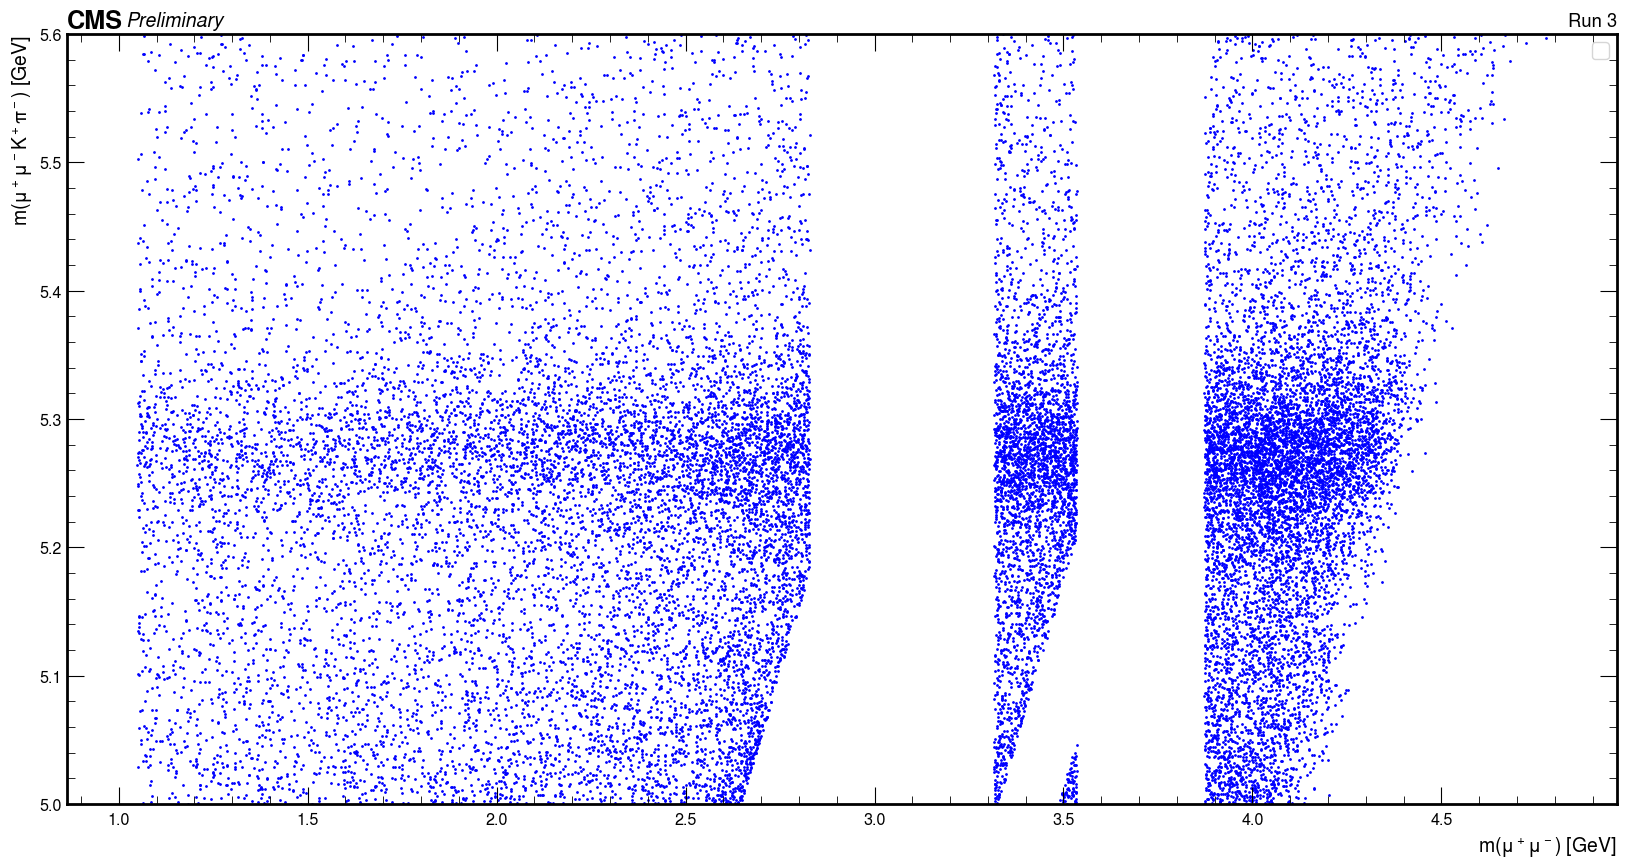

In [4]:
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(20, 10))

plt.scatter(df_Data.massJ, df_Data.massB_test, s=1, alpha=1, color="blue")
plt.ylim(5.0, 5.6)
# plt.xlim(2.0, 4.8) 
plt.xlabel(r"$m(\mu^+\mu^-)$ [GeV]")
plt.ylabel(r"$m(\mu^+\mu^-K^+ \pi^-)$ [GeV]")
plt.legend(loc='upper right', frameon=True, fontsize=12)
hep.cms.label(data=True, label="Preliminary", rlabel="Run 3")


plt.show()

In [5]:
print(df_Data.columns.tolist())

['masskstar_test', 'massB_test', 'massB1', 'massB2', 'massvetopipi', 'massvetokk', 'masskstar1', 'masskstar2', 'massJ', 'cosalfaB', 'Bdl', 'Bpt', 'Pi1pt', 'Pi2pt', 'mu1pt', 'mu2pt', 'mu1eta', 'mu2eta', 'Jprob', 'Bprob', 'priVtxCL', 'muon_dca', 'BdlE', 'nVtx', 'CosThetaK', 'CosThetaL', 'Phi', 'score', 'prediction', 'q2']


Graficando 21 variables seleccionadas...


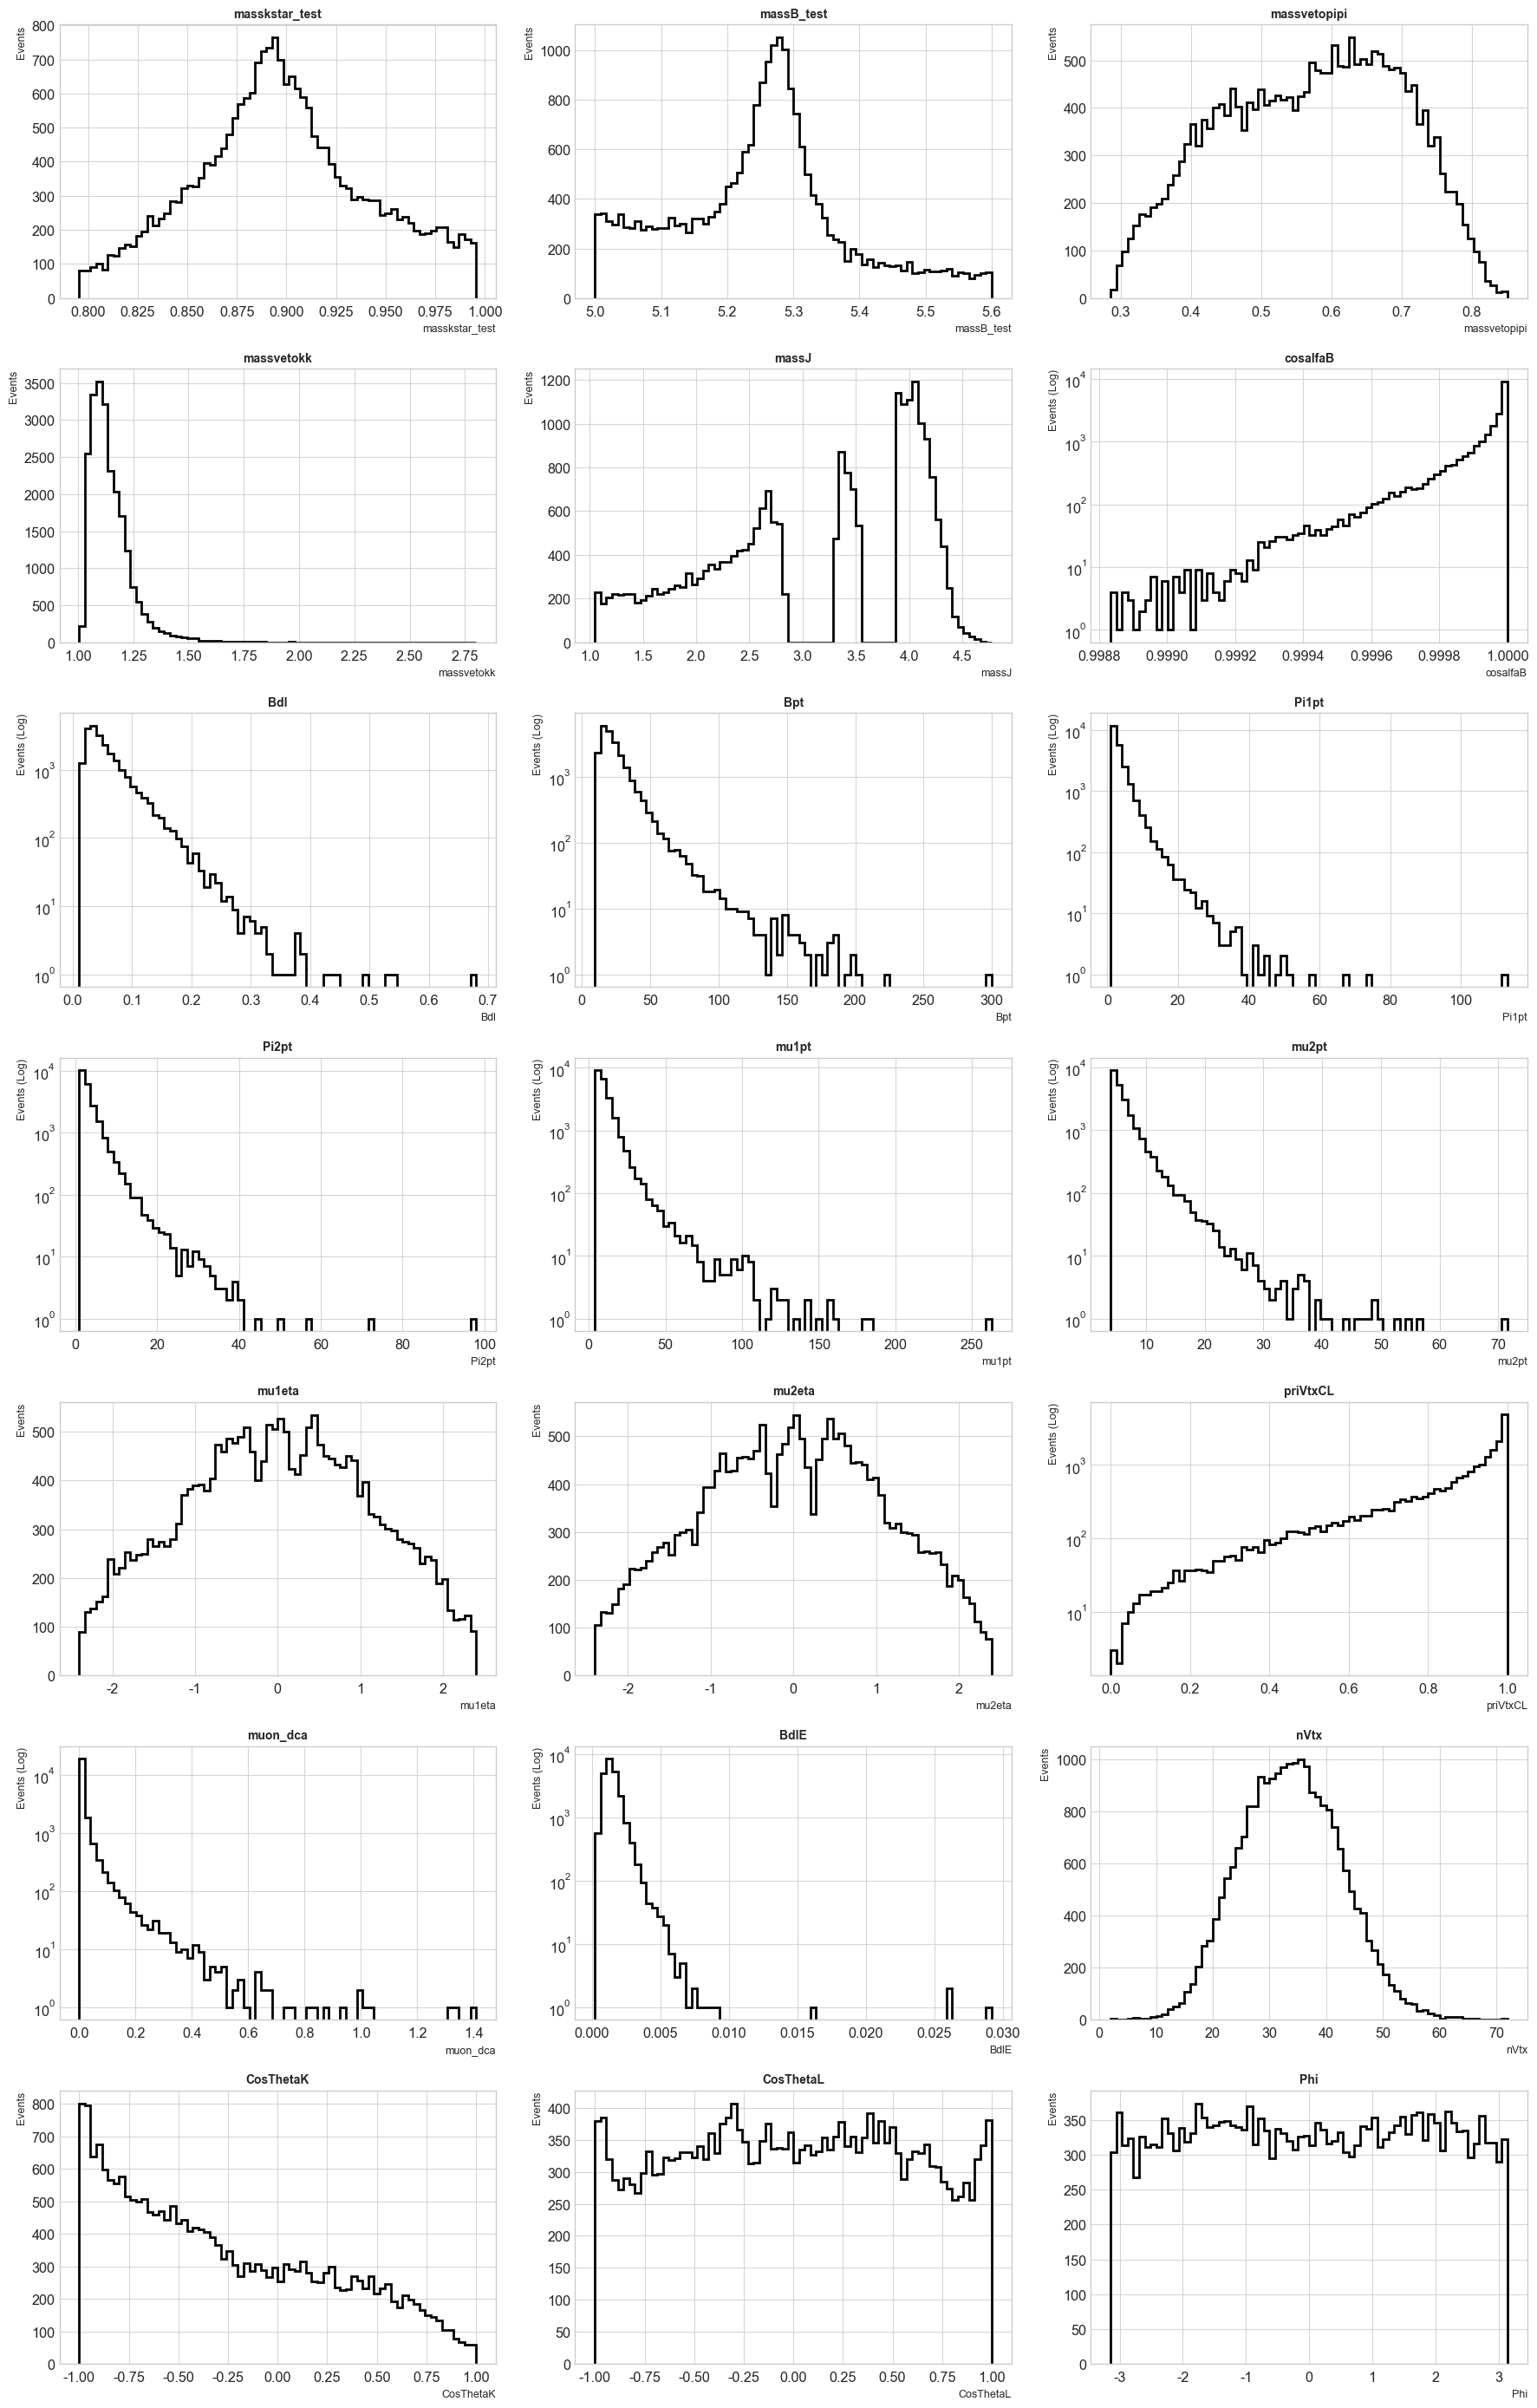

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math


variables_interes = [
'masskstar_test', 'massB_test', 'massvetopipi', 'massvetokk', 'massJ', 'cosalfaB', 'Bdl', 'Bpt', 'Pi1pt', 'Pi2pt', 'mu1pt', 'mu2pt', 'mu1eta', 'mu2eta', 'priVtxCL', 'muon_dca', 'BdlE', 'nVtx', 'CosThetaK', 'CosThetaL', 'Phi'
 ]  

#log
variables_con_log = [
'cosalfaB', 'Bdl', 'Bpt', 'Pi1pt', 'Pi2pt', 'mu1pt', 'mu2pt', 'priVtxCL', 'muon_dca', 'BdlE'

] 


variables_a_graficar = [var for var in variables_interes if var in df_Data.columns]
n_vars = len(variables_a_graficar)

n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))

if n_vars > 1:
    axes = axes.flatten()
else:
    axes = [axes] 

print(f"Graficando {n_vars} variables seleccionadas...")

for i, var_name in enumerate(variables_a_graficar):
    data = df_Data[var_name].dropna()
    
    axes[i].hist( data,  bins=70,  histtype='step', color='black', linewidth=2, label=var_name     
    )
    
    if var_name in variables_con_log:
        axes[i].set_yscale('log')
        ylab = "Events (Log)"
    else:
        ylab = "Events"

    axes[i].set_title(f"{var_name}", fontsize=10, fontweight='bold')
    axes[i].set_xlabel(var_name, fontsize=9)
    axes[i].set_ylabel(ylab, fontsize=9)

for j in range(n_vars, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Graficando variables angulares estilo CMS...


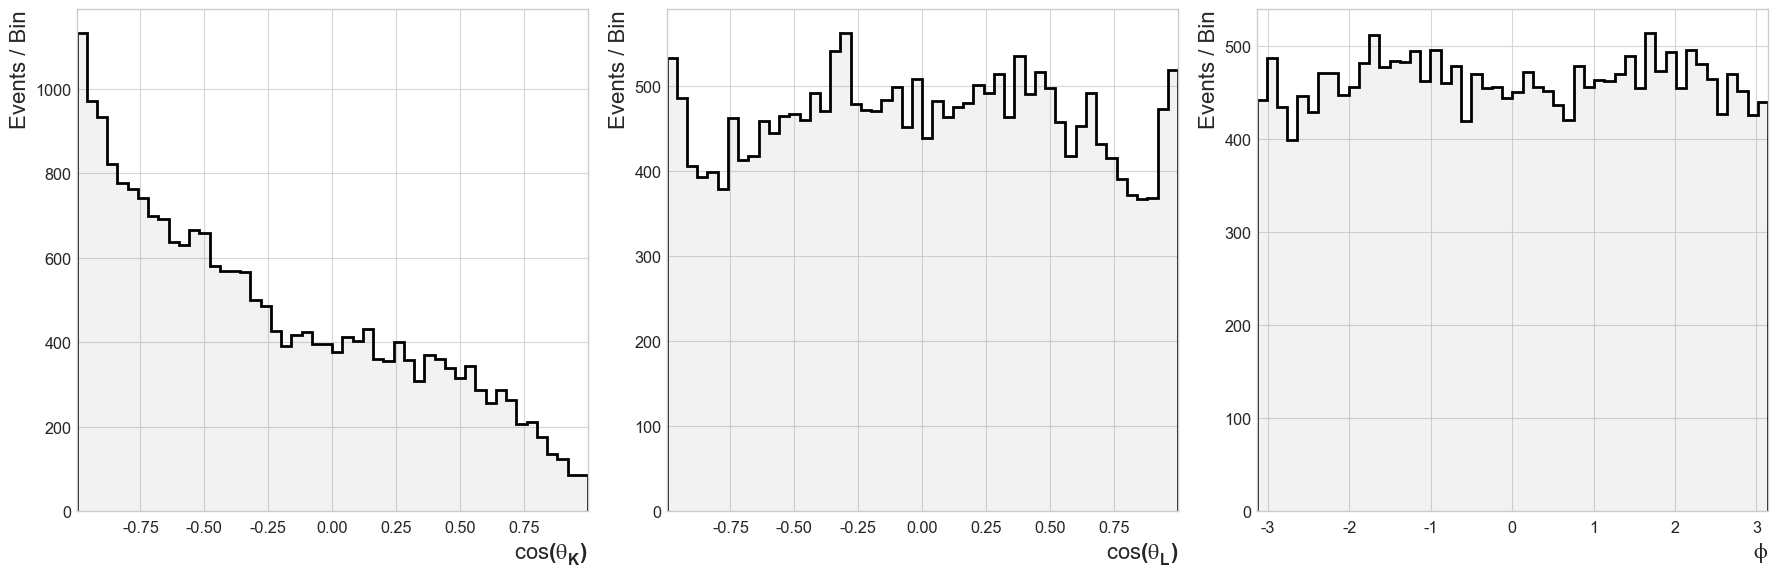

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Configuración de Estilo CMS Manual (imitación)
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 14,
    "axes.labelsize": 16,
    "xtick.direction": "in",  # Ticks hacia adentro
    "ytick.direction": "in",
    "xtick.top": True,        # Ticks arriba también
    "ytick.right": True,      # Ticks a la derecha también
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "lines.linewidth": 2
})

# 2. Definir variables específicas
variables_angulares = ['CosThetaK', 'CosThetaL', 'Phi']

# Diccionario para etiquetas bonitas en LaTeX (opcional, para que se vea más pro)
etiquetas_latex = {
    'CosThetaK': r'$\cos(\theta_K)$',
    'CosThetaL': r'$\cos(\theta_{L})$',
    'Phi': r'$\phi$'
}

# 3. Configurar el canvas (1 fila, 3 columnas)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Si solo hubiera 1 variable, axes no sería una lista, esto asegura que lo sea
if len(variables_angulares) == 1:
    axes = [axes]

print(f"Graficando variables angulares estilo CMS...")

for i, var_name in enumerate(variables_angulares):
    # Verificar si la variable existe en tu df_Data
    if var_name in df_Data.columns:
        data = df_Data[var_name].dropna()
        ax = axes[i]
        
        # Histograma principal
        # CMS suele usar color negro solido o puntos con barras de error.
        # Aquí usamos 'step' negro grueso como pediste.
        counts, bins, _ = ax.hist(
            data, 
            bins=50, 
            range=(data.min(), data.max()), # Asegura rango completo
            histtype='step', 
            color='black', 
            linewidth=2, 
            label='Data'
        )
        
        # Rellenar ligeramente bajo la curva (opcional, se ve bien)
        ax.hist(data, bins=bins, histtype='stepfilled', color='gray', alpha=0.1)

        # Etiquetas
        xlabel = etiquetas_latex.get(var_name, var_name) # Usa LaTeX si existe, sino el nombre original
        ax.set_xlabel(xlabel, fontweight='bold', loc='right') # Etiqueta a la derecha (estilo ROOT/CMS)
        ax.set_ylabel("Events / Bin", loc='top')
        
        # Límites y formato
        ax.set_xlim(data.min(), data.max())
        
        # Añadir etiqueta "CMS" dentro del gráfico
        # El estilo CMS pone "CMS" en negrita arriba a la izquierda


    else:
        print(f"Advertencia: {var_name} no encontrada en el DataFrame.")
        axes[i].axis('off')

plt.tight_layout()
plt.show()